Found cached dataset parquet (/Users/jay/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-10e3527a764857bd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.45it/s]


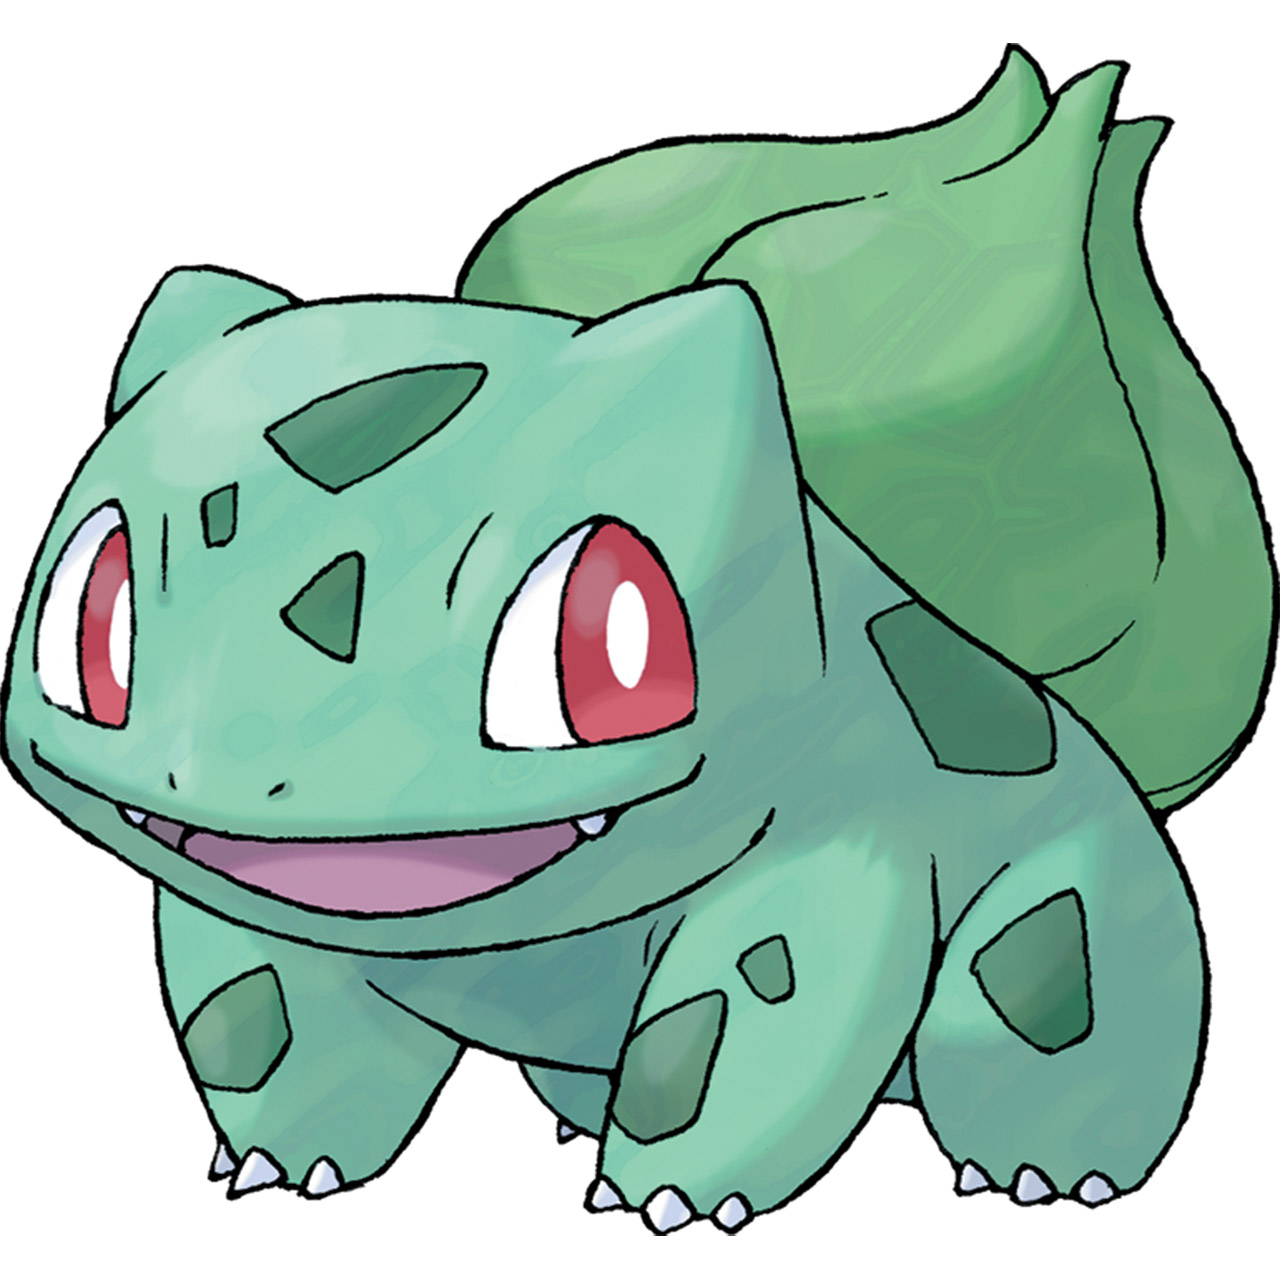

Epoch index : 0. Batch index: 0. Loss: 1.0295207500457764.


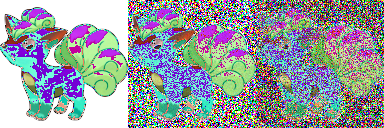

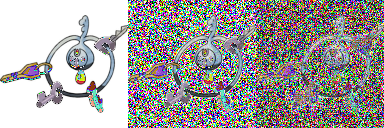

Epoch index : 0. Batch index: 2. Loss: 1.0634491443634033.


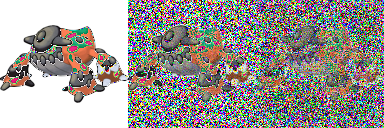

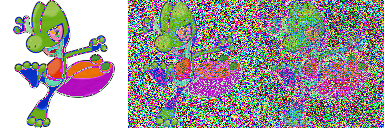

Epoch index : 0. Batch index: 4. Loss: 1.032413125038147.


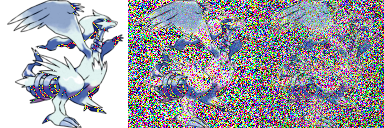

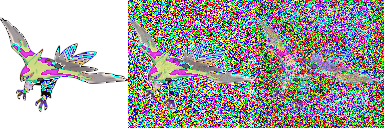

Epoch index : 0. Batch index: 6. Loss: 1.041593074798584.


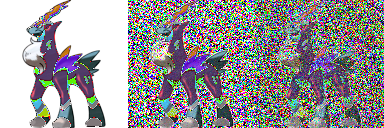

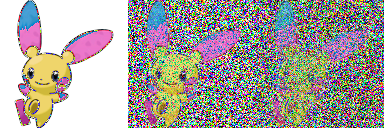

Epoch index : 0. Batch index: 8. Loss: 1.0346438884735107.


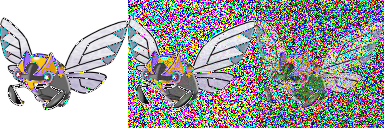

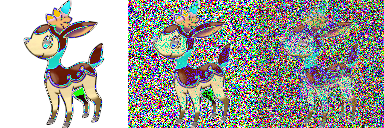

Epoch index : 0. Batch index: 10. Loss: 1.0147799253463745.


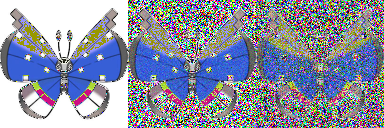

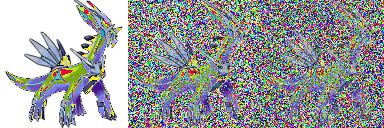

Epoch index : 0. Batch index: 12. Loss: 1.008908987045288.


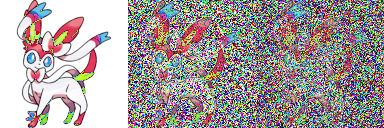

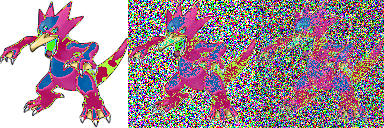

Epoch index : 0. Batch index: 14. Loss: 1.0105581283569336.


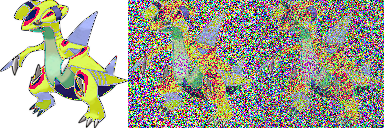

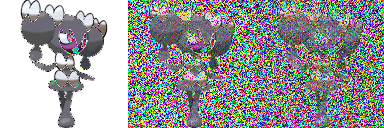

Epoch index : 0. Batch index: 16. Loss: 1.0074824094772339.


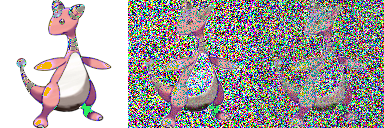

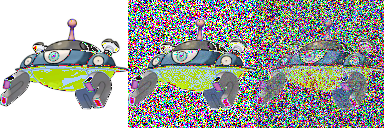

Epoch index : 0. Batch index: 18. Loss: 1.001770257949829.


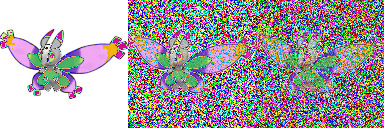

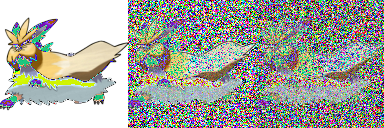

Epoch index : 0. Batch index: 20. Loss: 0.9935473799705505.


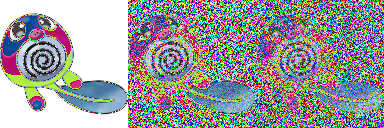

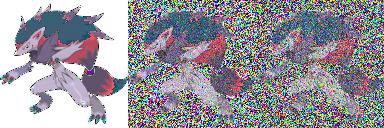

Epoch index : 0. Batch index: 22. Loss: 0.9992504119873047.


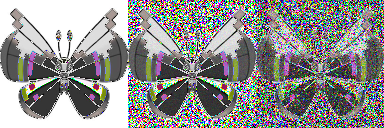

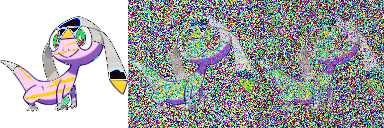

Epoch index : 0. Batch index: 24. Loss: 1.0044113397598267.


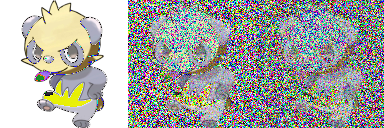

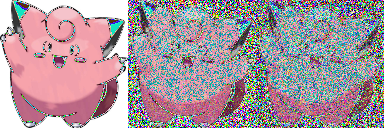

Epoch index : 0. Batch index: 26. Loss: 1.0011485815048218.


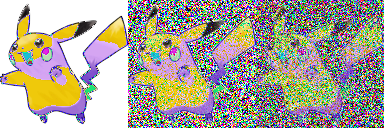

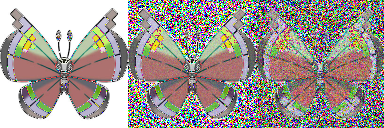

Epoch index : 0. Batch index: 28. Loss: 0.9927325248718262.


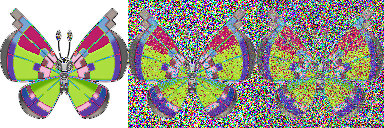

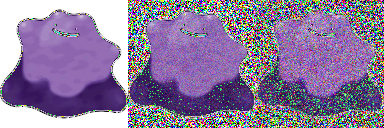

Epoch index : 0. Batch index: 30. Loss: 1.0089722871780396.


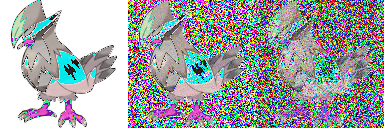

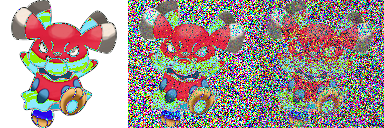

Epoch index : 0. Batch index: 32. Loss: 0.997748076915741.


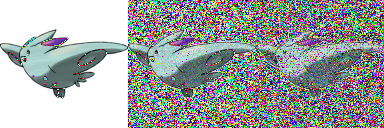

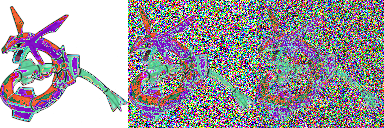

Epoch index : 0. Batch index: 34. Loss: 1.0009500980377197.


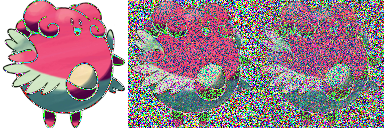

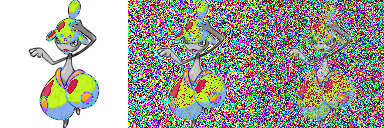

Epoch index : 0. Batch index: 36. Loss: 1.0015007257461548.


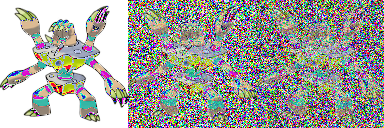

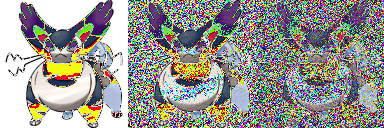

Epoch index : 0. Batch index: 38. Loss: 1.0050114393234253.


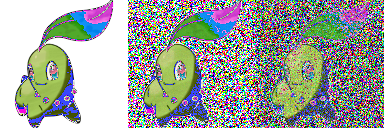

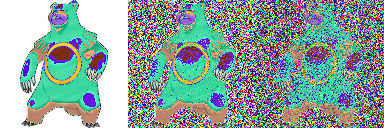

In [7]:
# Trainer script for training image diffusion models.

# Import parent directory path so that other imports work.
import sys, os
sys.path.append(os.path.abspath(".."))

from PIL import Image
from datasets import load_dataset
from dataset_utils.dataset_utils import verify_columns, visualize_dataset, preprocess_dataset, collate_fn
from layers.unet import UNetWithCrossAttention
from noise_schedulers.scheduler import NoiseScheduler
from evaluator.evaluate_utils import visualize_predictions
import torch
from transformers import CLIPTokenizer, tokenization_utils_base
from typing import Union, Optional, Any
from functools import partial
from diffusers import AutoencoderKL
from dataclasses import dataclass
from torch import nn
import math


# Hyperparameters
# Dataset hyper parameters.
dataset_name = 'lambdalabs/pokemon-blip-captions'
tokenizer_name = 'CompVis/stable-diffusion-v1-4'
text_encoder_name = 'CompVis/stable-diffusion-v1-4'
image_encoder_name = 'CompVis/stable-diffusion-v1-4'
train_split_name = 'train'
image_column = 'image'
caption_column = 'text'

# Architecture hyperparamters.
down_sizes = [256, 128, 64]
up_sizes = [64, 128, 256]

# Training hyper parameters.
seed = 123
batch_size = 4
num_epochs = 1
num_batches = 40
num_batches_to_visualize = 2
max_time_steps = 100

# Setting device.
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        ValueError("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        ValueError("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

device = torch.device('mps')

# Load dataset, verify columns and dataloader.
torch.manual_seed(seed)
dataset = load_dataset(dataset_name)
assert train_split_name in dataset.keys(), f'{train_split_name} is not a valid key in the dataset dictionary.'
train_dataset = dataset[train_split_name]
verify_columns(train_dataset, image_column, caption_column)
visualize_dataset(train_dataset, image_column, caption_column, False)

tokenizer = CLIPTokenizer.from_pretrained(tokenizer_name, subfolder="tokenizer")
preprocess_dataset_partial = partial(preprocess_dataset, image_size = 128, image_column = image_column, caption_column = caption_column, tokenizer = tokenizer)
train_dataset.set_transform(preprocess_dataset_partial)
visualize_dataset(train_dataset, image_column, caption_column, tokenizer, False)

collate_fn_partial = partial(collate_fn, tokenizer = tokenizer)
train_dataloader = torch.utils.data.DataLoader(dataset['train'], shuffle = True, batch_size = batch_size, collate_fn = collate_fn_partial)

# Define model and optimizer.
model = UNetWithCrossAttention(skip_connections = True)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-3)
noise_scheduler = NoiseScheduler(max_time_steps, device)

# Train model.
for epoch_index in range(num_epochs):
    for batch_index, batch in enumerate(train_dataloader):
        if batch_index >= num_batches:
            break
        input_image = batch['image'].to(device)
        noisy_image, epsilons = noise_scheduler.add_noise(input_image)
        input_text = batch['text'].to(device)
        noise_predictions = model(noisy_image, input_text)
        optimizer.zero_grad()
        loss = nn.MSELoss()(epsilons, noise_predictions)
        loss.backward()
        optimizer.step()
        if batch_index % num_batches_to_visualize == 0:
            print(f'Epoch index : {epoch_index}. Batch index: {batch_index}. Loss: {loss}.')
            denoised_image = noisy_image
            for time_step in range(max_time_steps, 0, -1):
                denoised_image = noise_scheduler.denoise(denoised_image, time_step, model, input_text)
            visualize_predictions(input_image, input_text, noisy_image, denoised_image)


In [6]:

import dataset_utils
